- price per area :  공시가격 / 전용면적 (X) -> 평균공시가격이 거의 해당 아파트의 진짜 평균가격.
 -> 공시가격을 전용면적으로 나눈 
- 2021~2023 k-fold
- 한남더힐 / 갤러리아포레

- test 에 없고 혼란을 주는 train 데이터를 지워도 좋을 것이다.

In [1]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pickle
import csv
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')
import gdown
import joblib

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

# 코드 셀 실행 후 경고를 무시
# import warnings
# warnings.filterwarnings(action='ignore')

### Load Table

In [2]:
# pickle에서 데이터프레임 다시 불러오기
with open('data.pickle', 'rb') as f:
    df = pickle.load(f)

In [3]:
df

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,동,계약년,계약월,평균공시가격,계약일,date
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,개포동,2017,12,120960.000000,8,2017-12-08
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,개포동,2017,12,120960.000000,22,2017-12-22
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,개포동,2017,12,120960.000000,28,2017-12-28
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,개포동,2018,01,120960.000000,3,2018-01-03
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,개포동,2018,01,120960.000000,8,2018-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,816.0,신내우디안1단지,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,19,2023-07-19
1128090,816,816.0,신내우디안1단지,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,07,39021.326676,25,2023-07-25
1128091,816,816.0,신내우디안1단지,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,08,39021.326676,27,2023-08-27
1128092,816,816.0,신내우디안1단지,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,Unknown,2023,09,39021.326676,2,2023-09-02


In [4]:
train_path = '../../data/train.csv'
test_path  = '../../data/test.csv'
dt_train = pd.read_csv(train_path)
dt_test = pd.read_csv(test_path)

# train/test 구분을 위한 칼럼을 하나 만들어 줍니다.
dt_train['is_test'] = 0
dt_test['is_test'] = 1
dt = pd.concat([dt_train, dt_test])

In [5]:
df['large_std_동'] = df['동']
df.drop(['동'], axis=1, inplace=True)

In [6]:
dt['동'] = dt['시군구'].apply(lambda x:x.split()[2])

In [7]:
dt = dt.reset_index()

In [8]:
df['동'] = dt['동']

In [9]:
df.head()

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,계약월,평균공시가격,계약일,date,large_std_동,동
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,12,120960.0,8,2017-12-08,개포동,개포동
1,658-1,658.0,개포6차우성,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,12,120960.0,22,2017-12-22,개포동,개포동
2,658-1,658.0,개포6차우성,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,12,120960.0,28,2017-12-28,개포동,개포동
3,658-1,658.0,개포6차우성,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,01,120960.0,3,2018-01-03,개포동,개포동
4,658-1,658.0,개포6차우성,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,01,120960.0,8,2018-01-08,개포동,개포동


### 년도에따라 동, 구별 statistics 추가

In [10]:
stats = df.groupby(['계약년', '구'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '구'], rsuffix='_target')

In [11]:
df['계약년과구에따른std'] = df['std']
df['계약년과구에따른mean'] = df['mean']
df['계약년과구에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약년,계약월,평균공시가격,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,2017,12,120960.0,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0


In [12]:
stats = df.groupby(['계약년', '동'])['target'].agg(['std', 'mean', 'max'])
df = df.join(stats, on=['계약년', '동'], rsuffix='_target')

In [13]:
df['계약년과동에따른std'] = df['std']
df['계약년과동에따른mean'] = df['mean']
df['계약년과동에따른max'] = df['max']
df.drop(['std', 'mean', 'max'], axis=1, inplace=True)
df.head(1)

,번지,본번,아파트명,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,...,계약일,date,large_std_동,동,계약년과구에따른std,계약년과구에따른mean,계약년과구에따른max,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,658.0,개포6차우성,79.97,201712,3,1987,언주로 3,124000.0,0,...,8,2017-12-08,개포동,개포동,60408.755329,127433.7879,1053000.0,32126.755612,108070.249556,260000.0


In [14]:
# '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max'의 null 값을
# '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max'의 값으로 채우기
df['계약년과동에따른std'] = df['계약년과동에따른std'].fillna(df['계약년과구에따른std'])
df['계약년과동에따른mean'] = df['계약년과동에따른mean'].fillna(df['계약년과구에따른mean'])
df['계약년과동에따른max'] = df['계약년과동에따른max'].fillna(df['계약년과구에따른max'])

In [15]:
df.drop(['동', 'large_std_동', '계약월', 'date', '본번', '계약년과구에따른std', '계약년과구에따른mean', '계약년과구에따른max', '계약일', '아파트명', '계약년'], axis=1, inplace=True)

### Feature Engineering

#### 240 이상 및 최고층 추가

In [16]:
df['펜트하우스'] = df['전용면적(㎡)'] > 240

In [17]:
df['펜트하우스'].value_counts()

False    1126454
True        1640
Name: 펜트하우스, dtype: int64

#### 계약년 추가 및 공시가격 2022, 2023 제외 np.nan

In [19]:
df['계약년'] = df['계약년'].astype('int')

In [20]:
df.loc[df['계약년'] < 2022, '평균공시가격'] = np.nan

In [21]:
df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,계약년,평균공시가격,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,2017,NaN,32126.755612,108070.249556,260000.0
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,2017,NaN,32126.755612,108070.249556,260000.0
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,2017,NaN,32126.755612,108070.249556,260000.0
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,2018,NaN,43598.058342,142378.337531,260000.0
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,2018,NaN,43598.058342,142378.337531,260000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,2023,39021.326676,11341.218441,54184.649123,85000.0
1128090,816,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,2023,39021.326676,11341.218441,54184.649123,85000.0
1128091,816,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,2023,39021.326676,11341.218441,54184.649123,85000.0
1128092,816,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,2023,39021.326676,11341.218441,54184.649123,85000.0


#### 재건축
- ~30: 관계없음
- 30~36 : 상향
- 38~45 : peak
- 44~ : 재건축실패

In [19]:
df['yrs_diff'] = df['계약년월'].map(lambda x : x // 100) - df['건축년도']

In [20]:
df

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,평균공시가격,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,yrs_diff
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,30
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,30
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,30
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,120960.000000,43598.058342,142378.337531,260000.0,31
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,120960.000000,43598.058342,142378.337531,260000.0,31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,2014,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,9
1128090,816,84.62,202307,12,2014,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,9
1128091,816,101.65,202308,12,2014,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,9
1128092,816,84.94,202309,18,2014,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,9


In [21]:
def 재건축(x):
    if x < 30:
        return '관계없음'
    elif x < 37:
        return '우상향'
    elif x < 45:
        return '피크'
    else:
        return '실패'

df['재건축구분'] = df['yrs_diff'].apply(재건축)

In [22]:
df.drop(['yrs_diff', '건축년도'], axis=1, inplace=True)

#### `전용면적(㎡)`에 따른 분류
- 원룸 < 35
- 소형아파트 < 85
- 중형아파트 < 135
- 대형아파트 < 200
- 대저택 

In [23]:
df_2015 = df.loc[df['계약년월'] > 201500, :]
df_2015

,번지,전용면적(㎡),계약년월,층,도로명,target,is_test,구,평균공시가격,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max,재건축구분
0,658-1,79.97,201712,3,언주로 3,124000.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,우상향
1,658-1,79.97,201712,4,언주로 3,123500.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,우상향
2,658-1,54.98,201712,5,언주로 3,91500.0,0,강남구,120960.000000,32126.755612,108070.249556,260000.0,우상향
3,658-1,79.97,201801,4,언주로 3,130000.0,0,강남구,120960.000000,43598.058342,142378.337531,260000.0,우상향
4,658-1,79.97,201801,2,언주로 3,117000.0,0,강남구,120960.000000,43598.058342,142378.337531,260000.0,우상향
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1128089,816,84.65,202307,13,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,관계없음
1128090,816,84.62,202307,12,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,관계없음
1128091,816,101.65,202308,12,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,관계없음
1128092,816,84.94,202309,18,신내역로1길 85,NaN,1,중랑구,39021.326676,11341.218441,54184.649123,85000.0,관계없음


In [24]:
df_2015.loc[df['전용면적(㎡)'] < 35, :]['target'].describe().round(2)

count     27881.00
mean      23527.33
std       16155.28
min        4500.00
25%       13000.00
50%       18500.00
75%       28000.00
max      128000.00
Name: target, dtype: float64

In [25]:
df_2015.loc[(df['전용면적(㎡)'] >= 35) & (df['전용면적(㎡)'] < 85), :]['target'].describe().round(2)

count    489707.00
mean      60067.88
std       37167.29
min         700.00
25%       35750.00
50%       49900.00
75%       73000.00
max      466000.00
Name: target, dtype: float64

In [26]:
df_2015.loc[(df['전용면적(㎡)'] >= 85) & (df['전용면적(㎡)'] < 135), :]['target'].describe().round(2)

count     92248.00
mean      95618.80
std       56416.67
min       17000.00
25%       57500.00
50%       79000.00
75%      118500.00
max      680000.00
Name: target, dtype: float64

In [27]:
df_2015.loc[(df['전용면적(㎡)'] >= 135) & (df['전용면적(㎡)'] < 200), :]['target'].describe().round(2)

count     23625.00
mean     161868.11
std       90595.70
min       29000.00
25%       96000.00
50%      141000.00
75%      200000.00
max      800000.00
Name: target, dtype: float64

In [28]:
df_2015.loc[(df['전용면적(㎡)'] >= 200), :]['target'].describe().round(2)

count       3275.00
mean      286740.16
std       166138.87
min        50000.00
25%       165000.00
50%       245000.00
75%       380000.00
max      1450000.00
Name: target, dtype: float64

In [29]:
def 면적구분하기(x):
    if x < 35:
        return '원룸'
    elif x < 85:
        return '소형아파트'
    elif x < 135:
        return '중형아파트'
    elif x < 200:
        return '대형아파트'
    else:
        return '저택'

df_2015['면적구분'] = df_2015['전용면적(㎡)'].apply(면적구분하기)

In [30]:
df = df_2015

In [31]:
df.drop(['전용면적(㎡)'], axis=1, inplace=True)

### Train

In [18]:
df.drop(['펜트하우스'], axis=1, inplace=True)

In [19]:
df.head()

,번지,전용면적(㎡),계약년월,층,건축년도,도로명,target,is_test,구,평균공시가격,계약년과동에따른std,계약년과동에따른mean,계약년과동에따른max
0,658-1,79.97,201712,3,1987,언주로 3,124000.0,0,강남구,120960.0,32126.755612,108070.249556,260000.0
1,658-1,79.97,201712,4,1987,언주로 3,123500.0,0,강남구,120960.0,32126.755612,108070.249556,260000.0
2,658-1,54.98,201712,5,1987,언주로 3,91500.0,0,강남구,120960.0,32126.755612,108070.249556,260000.0
3,658-1,79.97,201801,4,1987,언주로 3,130000.0,0,강남구,120960.0,43598.058342,142378.337531,260000.0
4,658-1,79.97,201801,2,1987,언주로 3,117000.0,0,강남구,120960.0,43598.058342,142378.337531,260000.0


In [20]:
df.shape

(1128094, 13)

In [21]:
df_train = df.loc[df['is_test']==0, :]
df_test = df.loc[df['is_test']==1, :]

df_train.drop(['is_test'], axis=1, inplace=True)
df_test.drop(['is_test'], axis=1, inplace=True)
print(df_train.shape, df_test.shape)

(1118822, 12) (9272, 12)


In [22]:
# 변수 삭제 및 파생변수 제작으로 추가된 변수들이 존재하기에, 다시한번 연속형과 범주형 칼럼을 분리해주겠습니다.
continuous_columns = []
categorical_columns = []

for column in df_train.columns:
    if pd.api.types.is_numeric_dtype(df_train[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

연속형 변수: ['전용면적(㎡)', '계약년월', '층', '건축년도', 'target', '평균공시가격', '계약년과동에따른std', '계약년과동에따른mean', '계약년과동에따른max']
범주형 변수: ['번지', '도로명', '구']


In [23]:
# 아래에서 범주형 변수들을 대상으로 레이블인코딩을 진행해 주겠습니다.

# 각 변수에 대한 LabelEncoder를 저장할 딕셔너리
label_encoders = {}

# Implement Label Encoding
for col in tqdm(categorical_columns):
    lbl = LabelEncoder()

    # Label-Encoding을 fit
    lbl.fit( df_train[col].astype(str) )
    df_train[col] = lbl.transform(df_train[col].astype(str))
    label_encoders[col] = lbl           # 나중에 후처리를 위해 레이블인코더를 저장해주겠습니다.

    # Test 데이터에만 존재하는 새로 출현한 데이터를 신규 클래스로 추가해줍니다.
    for label in np.unique(df_test[col]):
      if label not in lbl.classes_: # unseen label 데이터인 경우
        lbl.classes_ = np.append(lbl.classes_, label) # 미처리 시 ValueError발생하니 주의하세요!

    df_test[col] = lbl.transform(df_test[col].astype(str))

100%|██████████| 3/3 [00:01<00:00,  2.97it/s]


In [39]:
y_train = df_train['target']
X_train = df_train.drop(['target'], axis=1)

# Split the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=2023)

### Ensemble

In [40]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

# GradientBoostingRegressor
gbr = GradientBoostingRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=2,
    learning_rate=0.1,
    loss='huber'
)

# XGBRegressor
xgb_params = {
    'n_estimators': 500,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.005,
    'objective': 'reg:squarederror'
}
xgbr = xgb.XGBRegressor(**xgb_params)

# LGBMRegressor
lgbm_params = {
    'n_estimators': 500,
    'max_depth': 5,
    'num_leaves': 64,
    'min_child_samples': 10,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
}
lgbmr = lgb.LGBMRegressor(**lgbm_params)

# RandomForestRegressor
rfr = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt'
)

In [27]:
from sklearn.metrics import mean_squared_error

In [ ]:
# GradientBoostingRegressor
gbr.fit(X_train, y_train)

In [43]:
y_pred_gbr = gbr.predict(X_val)
rmse_gbr = np.sqrt(mean_squared_error(y_val, y_pred_gbr))
print(f"GBR RMSE: {rmse_gbr:.4f}")

GBR RMSE: 8836.4136


In [44]:
# RandomForestRegressor
rfr.fit(X_train, y_train)
y_pred_rfr = rfr.predict(X_val)
rmse_rfr = np.sqrt(mean_squared_error(y_val, y_pred_rfr))
print(f"RandomForestRegressor RMSE: {rmse_rfr:.4f}")

RandomForestRegressor RMSE: 13885.2798


In [45]:
xgb_model = xgb.XGBRegressor(n_estimators=2000, max_depth=16, max_leaves=60,
                             colsample_bytree=0.8, subsample=0.9, verbosity=0)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='rmse',
              early_stopping_rounds=30,
              verbose=50)

[0]	validation_0-rmse:39864.81066	validation_1-rmse:39931.94007
[50]	validation_0-rmse:9013.19642	validation_1-rmse:9129.72061
[100]	validation_0-rmse:7822.51307	validation_1-rmse:8058.36125
[150]	validation_0-rmse:7170.87793	validation_1-rmse:7500.27319
[200]	validation_0-rmse:6740.68193	validation_1-rmse:7168.04777
[250]	validation_0-rmse:6410.03696	validation_1-rmse:7014.19216
[300]	validation_0-rmse:6145.74687	validation_1-rmse:6881.90274
[350]	validation_0-rmse:5935.34751	validation_1-rmse:6836.22316
[397]	validation_0-rmse:5762.06690	validation_1-rmse:6810.08324


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=60,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [46]:
gbm = lgb.LGBMRegressor(n_estimators=2000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 8437.24	training's l2: 7.1187e+07	valid_1's rmse: 8507.91	valid_1's l2: 7.23845e+07
[200]	training's rmse: 7303.31	training's l2: 5.33384e+07	valid_1's rmse: 7311.88	valid_1's l2: 5.34636e+07
[300]	training's rmse: 6728.58	training's l2: 4.52738e+07	valid_1's rmse: 6816.6	valid_1's l2: 4.6466e+07
[400]	training's rmse: 6352.05	training's l2: 4.03485e+07	valid_1's rmse: 6486.25	valid_1's l2: 4.20715e+07
[500]	training's rmse: 6070.16	training's l2: 3.68469e+07	valid_1's rmse: 6285.4	valid_1's l2: 3.95063e+07
[600]	training's rmse: 5851.87	training's l2: 3.42444e+07	valid_1's rmse: 6129.77	valid_1's l2: 3.7574e+07
[700]	training's rmse: 5666.41	training's l2: 3.21083e+07	valid_1's rmse: 6030.81	valid_1's l2: 3.63707e+07
[800]	training's rmse: 5513.34	training's l2: 3.03969e+07	valid_1's rmse: 5935.9	valid_1's l2: 3.52349e+07
[900]	training's rmse: 5380.46	training's l2: 2.89494e+07	valid_1's rmse: 5848.81

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=2000, num_leaves=60, verbosity=-1)

In [47]:
X_test = df_test.drop(['target'], axis=1)
gbr_pred = gbr.predict(X_test)
rfr_pred = rfr.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
gbm_pred = gbm.predict(X_test)

In [62]:
gbr_score = 8836.4136
xgb_score = 6810.08324
lgb_score = 5567.64
rfr_score = 13885.2798
total_weight = (1. / gbr_score) + (1. / xgb_score) + (1. / lgb_score) + ((1. / rfr_score))

pred = (gbr_pred * (1. / gbr_score) + xgb_pred * (1. / xgb_score) +  gbm_pred * (1. / lgb_score) +  rfr_pred * (1. / rfr_score)) / total_weight
preds_df = pd.DataFrame(pred.astype(int), columns=["target"])
preds_df.to_csv('ensemble.csv', index=False)

In [63]:
preds_df.describe().round(2)

,target
count,9272.00
mean,106713.69
std,72979.30
min,9955.00
25%,63349.75
50%,88242.00
75%,126415.00
max,1088714.00


### Stacking, blending

In [28]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline

In [29]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [69]:
# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))
svr_model_full_data = svr.fit(X_train, y_train)

y_pred_svr = svr_model_full_data.predict(X_val)
rmse_svr = np.sqrt(mean_squared_error(y_val, y_pred_svr))
print(f"GBR RMSE: {rmse_svr:.4f}")

In [30]:
# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas))

# Fit model
ridge.fit(X_train, y_train)

# Evaluation
y_pred_ridge = ridge.predict(X_val)
rmse_ridge = np.sqrt(mean_squared_error(y_val, y_pred_ridge))

print(f"Ridge Regression RMSE: {rmse_ridge:.4f}")

Ridge Regression RMSE: 18231.9169


In [31]:
y_pred_ridge.max()

568083.6168560184

In [32]:
from catboost import CatBoostRegressor

# CatBoostRegressor 객체 생성 및 하이퍼파라미터 설정
cat_model = CatBoostRegressor(
    n_estimators=2000,       # 트리 개수를 늘림
    max_depth=10,            # 적절한 깊이로 설정
    task_type='GPU'          # GPU 사용
)

# 모델 학습
cat_model.fit(
    X_train, y_train,        # 학습 데이터
    eval_set=(X_val, y_val), # 평가 데이터
    metric_period=200,       # 200번째 반복마다 평가 지표 출력
    early_stopping_rounds=100,# 100번 반복 동안 성능 향상 없으면 조기 종료
    use_best_model=True      # 가장 좋은 성능의 모델 사용
)

Learning rate set to 0.102253
0:	learn: 48327.4538058	test: 48619.5532798	best: 48619.5532798 (0)	total: 11ms	remaining: 22s
200:	learn: 8167.2951002	test: 8373.8653695	best: 8373.8653695 (200)	total: 1.26s	remaining: 11.3s
400:	learn: 7159.2353862	test: 7544.9577932	best: 7544.9577932 (400)	total: 2.48s	remaining: 9.91s
600:	learn: 6623.1108925	test: 7201.8054241	best: 7200.8690040 (599)	total: 3.72s	remaining: 8.65s
800:	learn: 6223.3390996	test: 6904.6120949	best: 6904.6120949 (800)	total: 4.95s	remaining: 7.4s
1000:	learn: 5956.2680953	test: 6743.6608581	best: 6743.6608581 (1000)	total: 6.18s	remaining: 6.17s
1200:	learn: 5742.8648886	test: 6611.0122474	best: 6610.4284537 (1199)	total: 7.41s	remaining: 4.93s
1400:	learn: 5577.4437577	test: 6489.3465939	best: 6487.6597696 (1399)	total: 8.63s	remaining: 3.69s
1600:	learn: 5455.0431651	test: 6426.1031495	best: 6425.7183757 (1598)	total: 9.86s	remaining: 2.46s
1800:	learn: 5356.7500182	test: 6363.0503225	best: 6358.0923406 (1791)	total

In [33]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = cat_model.predict(X_test)
preds_df = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df.describe()

,target
count,9.272000e+03
mean,1.079384e+05
std,7.610424e+04
min,9.274000e+03
25%,6.362100e+04
50%,8.826600e+04
75%,1.275675e+05
max,1.026319e+06


### Optuna

In [25]:
import optuna

In [25]:
import optuna
import xgboost as xgb

def objective(trial):
    param_grid = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'eta': trial.suggest_float('eta', 0.01, 0.1),
        'reg_alpha': trial.suggest_int('reg_alpha', 1, 50),
        'reg_lambda': trial.suggest_int('reg_lambda', 1, 100),
        'min_child_weight': trial.suggest_int('min_child_weight', 2, 20),
    }


    model = xgb.XGBRegressor(**param_grid)

    # Train the model
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)

    # Compute the validation RMSE
    val_rmse = model.evals_result()['validation_0']['rmse'][-1]
    return val_rmse

def optimize_hyperparameters(n_trials=100):
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=n_trials)

    # Get the best hyperparameters
    best_params = study.best_trial.params

    # Create the final model with the best hyperparameters
    best_model = xgb.XGBRegressor(**best_params)

    # Train the final model
    best_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=50, verbose=False)

    return best_model

In [ ]:
xgb_best_model = optimize_hyperparameters(n_trials=100)
joblib.dump(xgb_best_model, 'best_xgb_model.pkl')

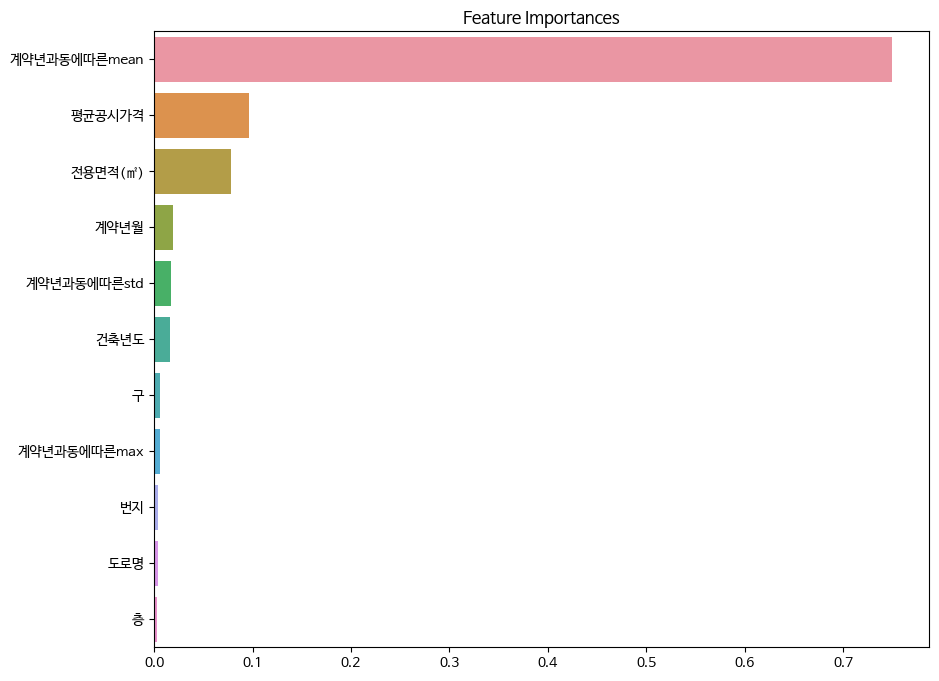

In [31]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = xgb_best_model.predict(X_test)
preds_df_xgb = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df_xgb.to_csv('final_xgb.csv', index=False)
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_best_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [32]:
preds_df_xgb.describe()

,target
count,9.272000e+03
mean,1.080469e+05
std,7.636763e+04
min,8.359000e+03
25%,6.317100e+04
50%,8.807850e+04
75%,1.279280e+05
max,1.131373e+06


In [27]:
# import optuna

# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     num_leaves = trial.suggest_int('num_leaves', 100, 1000)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#     lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
#     lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

#     # Create the LGBMRegressor model with the suggested hyperparameters
#     gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves, feature_fraction=feature_fraction,
#                             bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

#     # Train the model
#     gbm.fit(
#         X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_val, y_val)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50)]
#         )
    
#     # Compute the validation RMSE
#     val_rmse = gbm.best_score_['valid_1']['rmse']
#     return val_rmse

# def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     # Get the best hyperparameters
#     best_params = study.best_trial.params

#     # Create the final model with the best hyperparameters
#     best_model = lgb.LGBMRegressor(**best_params)

#     # Train the final model with early stopping and evaluation logging
#     best_model.fit(X_train, y_train,
#                    eval_set=[(X_train, y_train), (X_val, y_val)],
#                    eval_metric='rmse',
#                    callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
#                               lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

#     return best_model

In [28]:
# lgb_best_model = optimize_hyperparameters(n_trials=100)
# joblib.dump(lgb_best_model, 'best_lgb_model.pkl')

### Model Train - XGBoost

In [40]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=2000, max_depth=16, max_leaves=60,
                             colsample_bytree=0.8, subsample=0.9, verbosity=0)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train), (X_val, y_val)],
              eval_metric='rmse',
              early_stopping_rounds=50,
              verbose=100)

[0]	validation_0-rmse:34994.49718	validation_1-rmse:35152.16696
[100]	validation_0-rmse:7455.04925	validation_1-rmse:8013.58735
[200]	validation_0-rmse:6496.88737	validation_1-rmse:7232.94732
[300]	validation_0-rmse:5983.80392	validation_1-rmse:6886.78357
[400]	validation_0-rmse:5646.03952	validation_1-rmse:6697.42995
[500]	validation_0-rmse:5384.83975	validation_1-rmse:6584.39444
[600]	validation_0-rmse:5174.69765	validation_1-rmse:6489.82049
[700]	validation_0-rmse:5009.39725	validation_1-rmse:6416.09916
[800]	validation_0-rmse:4869.31812	validation_1-rmse:6360.76493
[900]	validation_0-rmse:4746.90002	validation_1-rmse:6333.40290
[1000]	validation_0-rmse:4639.57430	validation_1-rmse:6304.12684
[1100]	validation_0-rmse:4549.18288	validation_1-rmse:6259.01997
[1200]	validation_0-rmse:4465.84811	validation_1-rmse:6233.12013
[1300]	validation_0-rmse:4391.71660	validation_1-rmse:6218.71689
[1366]	validation_0-rmse:4347.22805	validation_1-rmse:6216.14536


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=16, max_leaves=60,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

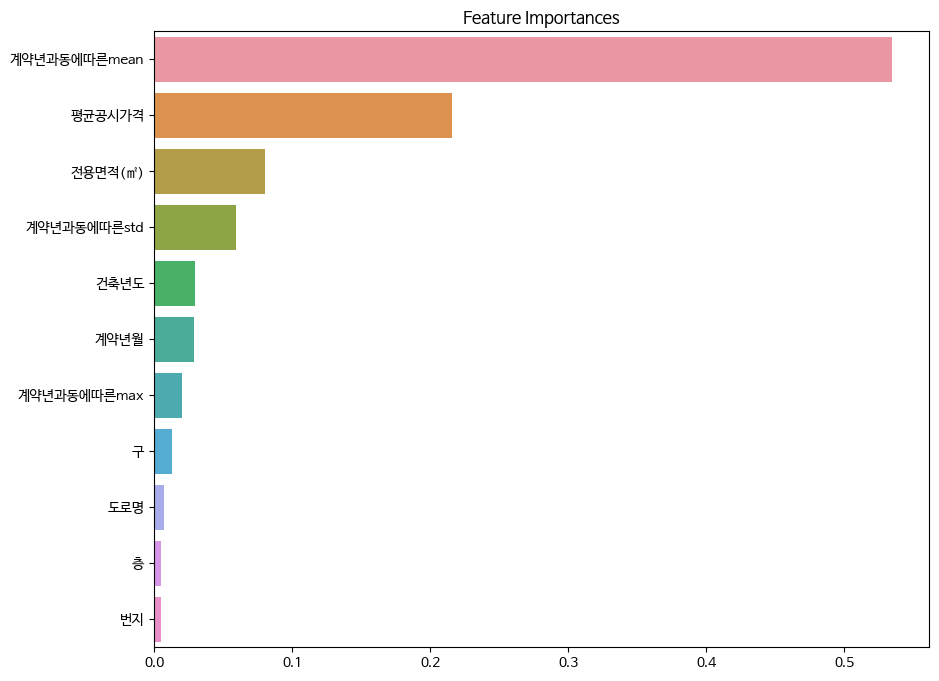

In [43]:
X_test = df_test.drop(['target'], axis=1)
real_test_pred = xgb_model.predict(X_test)
preds_df_xgb = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df_xgb.to_csv('final_xgb.csv', index=False)
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(xgb_model.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [44]:
preds_df_xgb.describe()

,target
count,9.272000e+03
mean,1.080626e+05
std,7.820053e+04
min,7.079000e+03
25%,6.316500e+04
50%,8.789700e+04
75%,1.272165e+05
max,1.297519e+06


### Model Train - lgb

In [29]:
# import optuna

# def objective(trial):
#     # Define the hyperparameter search space
#     n_estimators = trial.suggest_int('n_estimators', 1000, 5000)
#     max_depth = trial.suggest_int('max_depth', 10, 50)
#     num_leaves = trial.suggest_int('num_leaves', 100, 1000)
#     min_child_samples = trial.suggest_int('min_child_samples', 50, 500)
#     feature_fraction = trial.suggest_float('feature_fraction', 0.5, 1.0)
#     bagging_fraction = trial.suggest_float('bagging_fraction', 0.5, 1.0)
#     lambda_l1 = trial.suggest_float('lambda_l1', 1e-8, 1.0, log=True)  # Increase L1 regularization
#     lambda_l2 = trial.suggest_float('lambda_l2', 1e-8, 1.0, log=True)  # Increase L2 regularization

#     # Create the LGBMRegressor model with the suggested hyperparameters
#     gbm = lgb.LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, num_leaves=num_leaves,
#                             min_child_samples=min_child_samples, feature_fraction=feature_fraction,
#                             bagging_fraction=bagging_fraction, lambda_l1=lambda_l1, lambda_l2=lambda_l2, verbosity=-1)

#     # Train the model
#     gbm.fit(
#         X_train, y_train, 
#         eval_set=[(X_train, y_train), (X_val, y_val)], 
#         eval_metric='rmse',
#         callbacks=[lgb.early_stopping(stopping_rounds=50),
#                    lgb.log_evaluation(period=100, show_stdv=True)]
#         )
    
#     # Compute the validation RMSE
#     val_rmse = gbm.best_score_['valid_1']['rmse']
#     return val_rmse

# def optimize_hyperparameters(n_trials=100, early_stopping=50, log_evaluation=100):
#     study = optuna.create_study(direction='minimize')
#     study.optimize(objective, n_trials=n_trials)

#     # Get the best hyperparameters
#     best_params = study.best_trial.params

#     # Create the final model with the best hyperparameters
#     best_model = lgb.LGBMRegressor(**best_params)

#     # Train the final model with early stopping and evaluation logging
#     best_model.fit(X_train, y_train,
#                    eval_set=[(X_train, y_train), (X_val, y_val)],
#                    eval_metric='rmse',
#                    callbacks=[lgb.early_stopping(stopping_rounds=early_stopping),
#                               lgb.log_evaluation(period=log_evaluation, show_stdv=True)])

#     return best_model

In [30]:
# best_model = optimize_hyperparameters(n_trials=100)

In [45]:
gbm = lgb.LGBMRegressor(n_estimators=3000, max_depth=32, num_leaves=60,
                            feature_fraction=0.8,
                            bagging_fraction=0.9, verbosity=-1)

gbm.fit(
        X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], 
        eval_metric='rmse',
        callbacks=[lgb.early_stopping(stopping_rounds=50),
                   lgb.log_evaluation(period=100, show_stdv=True)]
        )

Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 7894.98	training's l2: 6.23306e+07	valid_1's rmse: 8308.92	valid_1's l2: 6.90381e+07
[200]	training's rmse: 6906.27	training's l2: 4.76966e+07	valid_1's rmse: 7404.47	valid_1's l2: 5.48261e+07
[300]	training's rmse: 6390.84	training's l2: 4.08428e+07	valid_1's rmse: 6964.29	valid_1's l2: 4.85014e+07
[400]	training's rmse: 6041.99	training's l2: 3.65056e+07	valid_1's rmse: 6707.72	valid_1's l2: 4.49934e+07
[500]	training's rmse: 5786.2	training's l2: 3.34801e+07	valid_1's rmse: 6521.59	valid_1's l2: 4.25312e+07
[600]	training's rmse: 5591.05	training's l2: 3.12599e+07	valid_1's rmse: 6384.24	valid_1's l2: 4.07585e+07
[700]	training's rmse: 5428.95	training's l2: 2.94735e+07	valid_1's rmse: 6267.5	valid_1's l2: 3.92815e+07
[800]	training's rmse: 5287.21	training's l2: 2.79546e+07	valid_1's rmse: 6179.14	valid_1's l2: 3.81817e+07
[900]	training's rmse: 5169.38	training's l2: 2.67225e+07	valid_1's rmse: 610

LGBMRegressor(bagging_fraction=0.9, feature_fraction=0.8, max_depth=32,
              n_estimators=3000, num_leaves=60, verbosity=-1)

In [64]:
# X_test = df_test.drop(['target'], axis=1)
real_test_pred = gbm.predict(X_test)
preds_df_lgb = pd.DataFrame(real_test_pred.astype(int), columns=["target"])
preds_df_lgb.to_csv('계약년과동에따른lgb.csv', index=False)

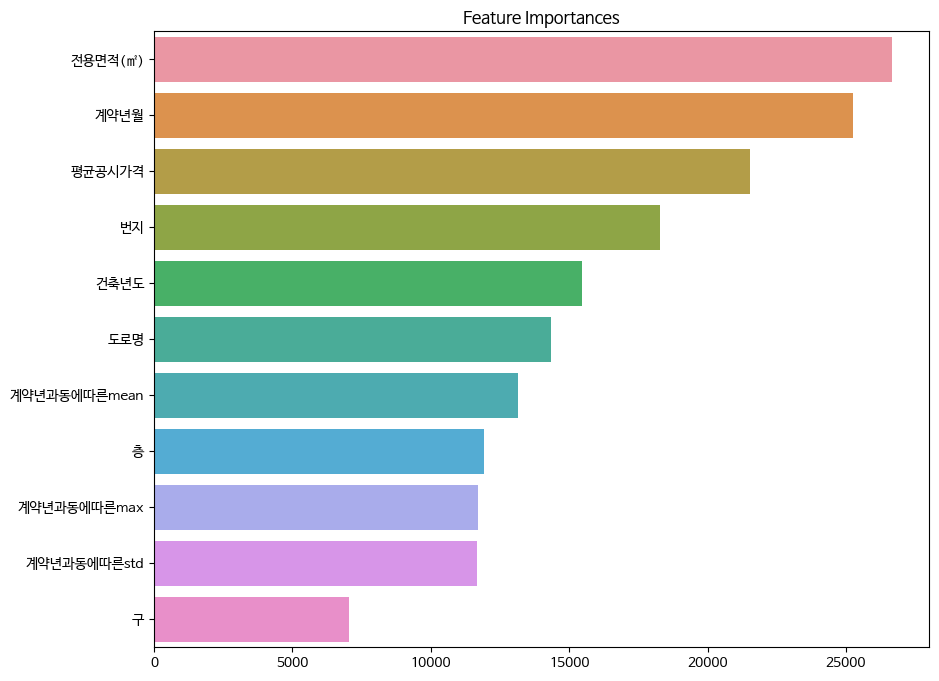

In [65]:
# 위 feature importance를 시각화해봅니다.
importances = pd.Series(gbm.feature_importances_, index=list(X_train.columns))
importances = importances.sort_values(ascending=False)

plt.figure(figsize=(10,8))
plt.title("Feature Importances")
sns.barplot(x=importances, y=importances.index)
plt.show()

In [48]:
preds_df_lgb.describe().round(2)

,target
count,9272.00
mean,107933.59
std,78043.68
min,8196.00
25%,63528.50
50%,88209.50
75%,127688.50
max,1297434.00


In [35]:
xgb_test_pred = xgb_model.predict(X_test)
lgb_test_pred = gbm.predict(X_test)
blended_test_pred = (xgb_test_pred + lgb_test_pred) / 2
blended_df = pd.DataFrame(blended_test_pred.astype(int), columns=["target"])

In [36]:
blended_df.to_csv('final_blended.csv', index=False)
blended_df.describe().round(2)

,target
count,9272.00
mean,108069.07
std,77748.62
min,1852.00
25%,63122.25
50%,88068.00
75%,127696.00
max,1254332.00


In [49]:
from mlxtend.regressor import StackingCVRegressor

In [51]:
# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgb_model, gbm),
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)

In [53]:
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))

In [58]:
stack_pred = stack_gen_model.predict(np.array(X_test))
stack_df = pd.DataFrame(stack_pred.astype(int), columns=["target"])

In [59]:
stack_df.describe().round(2)

,target
count,9272.00
mean,107801.52
std,77807.25
min,7336.00
25%,63116.50
50%,88235.00
75%,128475.00
max,1317519.00


In [60]:
blended_score = (0.3 * xgb_model.predict(X_test)) + (0.3 * gbm.predict(X_test)) + (0.4 * stack_gen_model.predict(np.array(X_test)))

In [62]:
blended_score_df = pd.DataFrame(blended_score.astype(int), columns=["target"])
blended_score_df.describe().round(2)

,target
count,9272.00
mean,107919.47
std,77884.75
min,8649.00
25%,63240.00
50%,88071.50
75%,128247.00
max,1305494.00


In [63]:
blended_score_df.to_csv('final_stacking_blended.csv', index=False)

In [70]:
blended_score_df

,target
0,184993
1,268166
2,290690
3,241742
4,198583
...,...
9267,72293
9268,72030
9269,78041
9270,72908


In [68]:
train_val.sort_values(by='err',ascending=False)

,시군구,아파트명,전용면적(㎡),층,계약년월,건축년도,target,pred,err
224567,서울특별시 강남구 청담동,PH129,273.960,16,202204,2020,1450000,1.099860e+06,350139.741039
534795,서울특별시 용산구 한남동,한남더힐,243.642,1,201707,2011,727000,4.973147e+05,229685.284571
138889,서울특별시 강남구 도곡동,타워팰리스3,214.967,66,200905,2004,450000,2.360779e+05,213922.129287
534713,서울특별시 용산구 한남동,한남더힐,240.305,1,201610,2011,630000,4.547177e+05,175282.276806
87271,서울특별시 용산구 한남동,한남더힐,244.749,3,201711,2011,760000,5.852729e+05,174727.104317
...,...,...,...,...,...,...,...,...,...
1105867,서울특별시 서초구 잠원동,신반포4,155.000,1,200702,1979,25000,1.503587e+05,-125358.667147
990274,서울특별시 서초구 반포동,반포주공1단지,106.250,2,201004,1973,37500,1.767860e+05,-139285.982556
1007680,서울특별시 강남구 압구정동,한양2,175.920,2,200712,1978,90000,2.426671e+05,-152667.135843
911051,서울특별시 강남구 압구정동,미성1차,153.320,6,201102,1982,35000,1.968025e+05,-161802.500081
